In [ ]:
# !pip install onnxruntime

In [ ]:
# Export to onnx
from ultralytics import YOLO
model = YOLO("best_re_final.pt")  
model.export(format="onnx",imgsz=[640,640], opset=12)  # export the model to ONNX format

In [4]:
import onnxruntime

opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

In [5]:
model_path = 'best_re_final.onnx'
EP_list = ['CUDAExecutionProvider', 'CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

In [6]:
model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_shape

[1, 3, 640, 640]

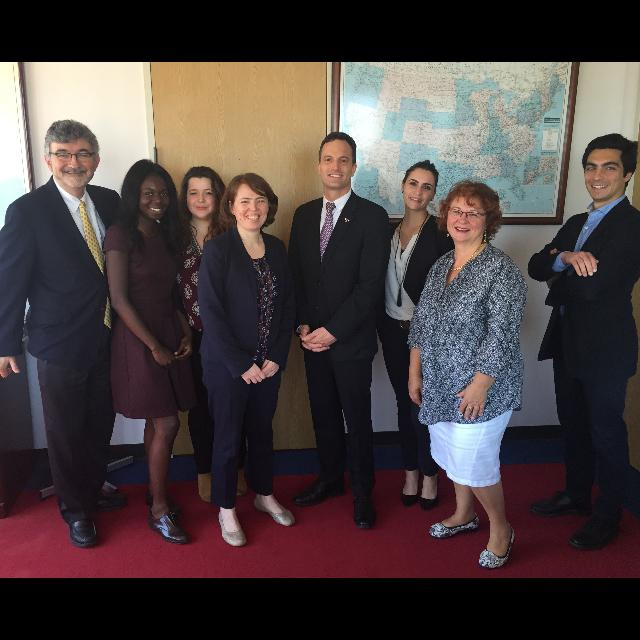

In [7]:
import cv2
import numpy as np
from PIL import Image

image = cv2.imread('test.jpg')
image_height, image_width = image.shape[:2]
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [8]:
input_height, input_width = input_shape[2:]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 640, 640)

In [12]:
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]

In [13]:
predictions = np.squeeze(outputs).T
conf_thresold = 0.8
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]  

In [14]:
# Get the class with the highest confidence
class_ids = np.argmax(predictions[:, 4:], axis=1)

In [15]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes

array([[ 71, 152,  57,  68],
       [ 71, 152,  57,  67],
       [ 71, 152,  57,  67],
       [337, 159,  41,  56],
       [ 71, 152,  56,  67],
       [ 71, 152,  57,  68],
       [ 71, 152,  57,  68],
       [337, 159,  41,  56],
       [337, 159,  41,  56],
       [337, 159,  41,  56],
       [609, 166,  51,  65],
       [ 71, 152,  57,  68],
       [ 71, 152,  57,  67],
       [ 71, 152,  57,  67],
       [337, 159,  41,  56],
       [337, 159,  41,  56],
       [337, 159,  40,  56],
       [609, 166,  51,  65],
       [609, 166,  51,  65],
       [609, 166,  51,  65],
       [ 71, 152,  57,  68],
       [337, 159,  41,  56],
       [337, 159,  40,  56],
       [337, 159,  41,  56],
       [418, 185,  37,  48],
       [609, 166,  51,  65],
       [609, 166,  51,  65],
       [609, 166,  51,  64],
       [148, 190,  44,  59],
       [148, 190,  43,  59],
       [202, 191,  36,  52],
       [419, 185,  37,  48],
       [418, 185,  37,  48],
       [418, 185,  37,  48],
       [609, 1

In [16]:
def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

# Apply non-maxima suppression to suppress weak, overlapping bounding boxes
indices = nms(boxes, scores, 0.3)

In [17]:
# Define classes 
CLASSES = [
 'head'
]

In [18]:
def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

In [19]:
image_draw = image.copy()
for (bbox, score, label) in zip(xywh2xyxy(boxes[indices]), scores[indices], class_ids[indices]):
    bbox = bbox.round().astype(np.int32).tolist()
    cls_id = int(label)
    cls = CLASSES[cls_id]
    color = (0,255,0)
    cv2.rectangle(image_draw, tuple(bbox[:2]), tuple(bbox[2:]), color, 2)
    cv2.putText(image_draw,
                f'{cls}:{int(score*100)}', (bbox[0], bbox[1] - 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.60, [225, 255, 255],
                thickness=1)

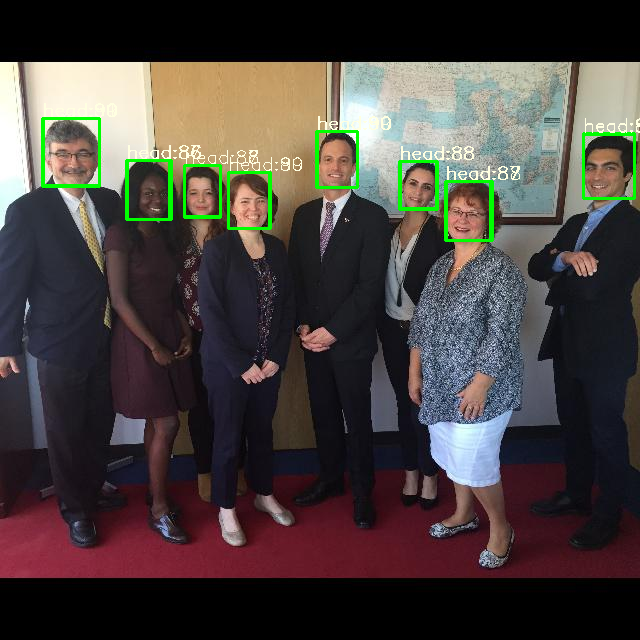

: 

In [23]:

Image.fromarray(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))

In [1]:
import matplotlib.pyplot as plt

In [2]:
!pip install streamlit

     ---------------------------------------- 8.1/8.1 MB 12.3 MB/s eta 0:00:00
     ------------------------------------- 471.5/471.5 kB 28.8 MB/s eta 0:00:00
     ---------------------------------------- 97.9/97.9 kB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 22.7 MB/s eta 0:00:00
     --------------------------------------- 21.5/21.5 MB 21.8 MB/s eta 0:00:00
     ---------------------------------------- 164.8/164.8 kB ? eta 0:00:00
     ------------------------------------- 239.7/239.7 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 188.5/188.5 kB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 4.7/4.7 MB 21.4 MB/s eta 0:00:00
     ---------------------------------------- 82.0/82.0 kB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 55.8/55.8 kB 2.8 MB/s eta 0:00:00
     ---------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\tr-abel.haile\\AppData\\Local\\miniconda3\\envs\\env1\\Lib\\site-packages\\~il\\_imaging.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

